In [ ]:
# I used google colab to run this notebook
# you have to install some packages

In [ ]:
%%capture
!pip install sklearn pandas numpu tensorflow
!pip install -q tensorflow-text
!pip install -q tf-models-official
!pip install sentence-transformers

In [ ]:
import tensorflow as tf
tf.device('/device:GPU:0')

## Imports, load data and constants definitions

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, accuracy_score

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.initializers import Constant
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (
    Input,
    Embedding,
    Bidirectional,
    LSTM,
    Dense,
    Dropout,
)
from tensorflow.keras.callbacks import EarlyStopping

# constants definition
VOCAB_SIZE =  389833 # less than the actual size (719994)
MAX_LENGTH = 64
EMBEDDING_SIZE = 100

# load train and test sets
train = pd.read_parquet("drive/MyDrive/ColabData/train.parquet")
test = pd.read_parquet("drive/MyDrive/ColabData/test.parquet")

X_train = np.array(train["tweet"].tolist())
y_train = np.array(train["sentiment"].tolist())
X_test = np.array(test["tweet"].tolist())
y_test = np.array(test["sentiment"].tolist())

## Embedding Layer from scratch

Create a model with a Embedding layer "randomly" initialized.

In [ ]:
# layer to encode text
encoder = TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=MAX_LENGTH)
encoder.adapt(X_train)

model = Sequential(
    [
        encoder,
        Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=EMBEDDING_SIZE,
            mask_zero=True,
        ),
        Bidirectional(LSTM(EMBEDDING_SIZE)),
        Dense(MAX_LENGTH, activation="relu"),
        Dropout(0.25),
        Dense(1, activation="sigmoid"),
    ]
)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# fit model and predict test set
model.fit(X_train, y_train, validation_split=0.1, batch_size=128, epochs=8, 
          callbacks=[EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)])
y_pred = model.predict(X_test)

Epoch 1/8
4756/4756 [==============================] - 1836s 383ms/step - loss: 0.4273 - accuracy: 0.8016 - val_loss: 0.3892 - val_accuracy: 0.8166
Epoch 2/8
4756/4756 [==============================] - 1811s 381ms/step - loss: 0.3298 - accuracy: 0.8559 - val_loss: 0.3766 - val_accuracy: 0.8278
Epoch 3/8
4756/4756 [==============================] - 1812s 381ms/step - loss: 0.2452 - accuracy: 0.8971 - val_loss: 0.4133 - val_accuracy: 0.8208
Epoch 4/8
4756/4756 [==============================] - 1791s 377ms/step - loss: 0.1821 - accuracy: 0.9242 - val_loss: 0.5316 - val_accuracy: 0.8112
Epoch 5/8
4756/4756 [==============================] - 1798s 378ms/step - loss: 0.1449 - accuracy: 0.9387 - val_loss: 0.6022 - val_accuracy: 0.8008


### Threshold Search
brute force to find best threshold.

In [ ]:
# brute force to find best threshold
accuracies = []
thresholds = np.arange(0, 1.01, .01)

for threshold in thresholds:
    y_pred_copy = y_pred.copy()
    y_pred_copy[y_pred_copy >= threshold] = 1
    y_pred_copy[y_pred_copy < threshold] = 0
    
    accuracies.append(accuracy_score(y_test, y_pred_copy))

# best threshold
threshold = thresholds[np.argmax(accuracies)]
y_pred[y_pred >= threshold] = 1
y_pred[y_pred < threshold] = 0

print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.62


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84    533571
           1       0.79      0.76      0.78    390037

    accuracy                           0.81    923608
   macro avg       0.81      0.81      0.81    923608
weighted avg       0.81      0.81      0.81    923608



### Quantification Analysis
Over time Qunatification Analysis, is the classifier a good quantifier?

In [ ]:
test["pred"] = y_pred.astype(int)
test["error"] = (test["sentiment"] !=  test["pred"]).astype(int)

error_quantity = test.groupby("date")["error"].sum().resample("D").sum() / test.groupby("date")["sentiment"].count().resample("D").sum()
# error_quantity = error_quantity.fillna(0)

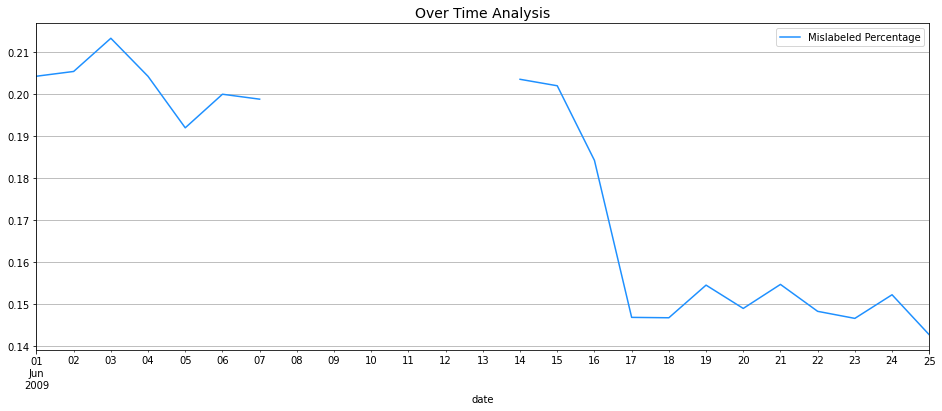

In [ ]:
error_quantity.plot(color="dodgerblue", grid=True, figsize=(16, 6))
plt.title("Over Time Analysis", fontsize=14)
plt.legend(["Mislabeled Percentage"])
plt.show()

---
## Pretrained Word Embeddings
Same model architecture, but Embedding layer is initialized with pre-trained word embeddings from GLoVe. Also, the Embedding layer is trainable.

In [ ]:
X_train = np.array(train["tweet"].tolist())
y_train = np.array(train["sentiment"].tolist())
X_test = np.array(test["tweet"].tolist())
y_test = np.array(test["sentiment"].tolist())

# layer to encode text
encoder = TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=MAX_LENGTH)
encoder.adapt(X_train)

NUM_TOKENS = len(encoder.get_vocabulary())

# load word embedding dict
path_to_glove_file = f"drive/MyDrive/ColabData/glove.twitter.27B.{EMBEDDING_SIZE}d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((NUM_TOKENS, EMBEDDING_SIZE))
for i, word in enumerate(encoder.get_vocabulary()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

print(f"Hit {hits} words ({misses} misses) - {(hits * 100 / (hits+misses)):.2f}%")

model = Sequential(
    [
        encoder,
        Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=EMBEDDING_SIZE,
            mask_zero=True,
            embeddings_initializer=Constant(embedding_matrix), # initialize embeddings using embedding matrix
            trainable=True, # trainable 
        ),
        Bidirectional(LSTM(EMBEDDING_SIZE)),
        Dense(MAX_LENGTH, activation="relu"),
        Dropout(0.25),
        Dense(1, activation="sigmoid"),
    ]
)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# fit model and predict test set
model.fit(X_train, y_train, validation_split=0.1, batch_size=128, epochs=8, 
          callbacks=[EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)])
y_pred = model.predict(X_test)

Hit 93127 words (173523 misses) - 34.92%
Epoch 1/8
4756/4756 [==============================] - 1499s 312ms/step - loss: 0.4146 - accuracy: 0.8088 - val_loss: 0.3747 - val_accuracy: 0.8319
Epoch 2/8
4756/4756 [==============================] - 1456s 306ms/step - loss: 0.3202 - accuracy: 0.8619 - val_loss: 0.3559 - val_accuracy: 0.8496
Epoch 3/8
4756/4756 [==============================] - 1447s 304ms/step - loss: 0.2479 - accuracy: 0.8953 - val_loss: 0.4655 - val_accuracy: 0.8077
Epoch 4/8
4756/4756 [==============================] - 1462s 307ms/step - loss: 0.2004 - accuracy: 0.9156 - val_loss: 0.4654 - val_accuracy: 0.8180
Epoch 5/8
4756/4756 [==============================] - 1462s 307ms/step - loss: 0.1612 - accuracy: 0.9325 - val_loss: 0.6629 - val_accuracy: 0.7964


### Threshold Search
brute force to find best threshold.

In [ ]:
# brute force to find best threshold
accuracies = []
thresholds = np.arange(0, 1.01, .01)

for threshold in thresholds:
    y_pred_copy = y_pred.copy()
    y_pred_copy[y_pred_copy >= threshold] = 1
    y_pred_copy[y_pred_copy < threshold] = 0
    
    accuracies.append(accuracy_score(y_test, y_pred_copy))

# best threshold
threshold = thresholds[np.argmax(accuracies)]
y_pred[y_pred >= threshold] = 1
y_pred[y_pred < threshold] = 0

print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.71


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85    533571
           1       0.81      0.75      0.78    390037

    accuracy                           0.82    923608
   macro avg       0.82      0.81      0.81    923608
weighted avg       0.82      0.82      0.82    923608



### Quantification Analysis
Over time Qunatification Analysis, is the classifier a good quantifier?

In [ ]:
test["pred"] = y_pred.astype(int)
test["error"] = (test["sentiment"] !=  test["pred"]).astype(int)

error_quantity = test.groupby("date")["error"].sum().resample("D").sum() / test.groupby("date")["sentiment"].count().resample("D").sum()
# error_quantity = error_quantity.fillna(0)

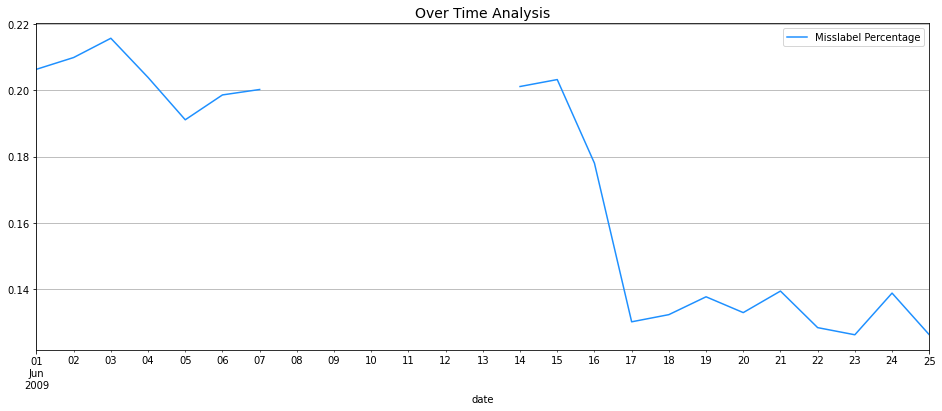

In [ ]:
error_quantity.plot(color="dodgerblue", grid=True, figsize=(16, 6))
plt.title("Over Time Analysis", fontsize=14)
plt.legend(["Misslabel Percentage"])
plt.show()

---
## Bert based classifier
Model based on tensorflow tutorial to fine tune a BERT-based classifier: https://www.tensorflow.org/tutorials/text/classify_text_with_bert.

In [ ]:
X_train = np.array(train["tweet"].tolist())
y_train = np.array(train["sentiment"].tolist())
X_test = np.array(test["tweet"].tolist())
y_test = np.array(test["sentiment"].tolist())

# pre-trained bert-based utils
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
tfhub_handle_encoder = (
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
)

# define model
text_input = Input(shape=(), dtype=tf.string, name="text")

# pre-trained layers
encoder_inputs = hub.KerasLayer(tfhub_handle_preprocess, trainable=False, name="preprocessing")(
    text_input
)
outputs = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name="BERT_encoder")(
    encoder_inputs
)
net = outputs["pooled_output"]

# last custom layers
drop = Dropout(0.25)(net)
dense = Dense(128)(drop)
out = Dense(1, activation="sigmoid")(dense)

model = Model(text_input, out)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# fit model and predict test set
model.fit(X_train, y_train, validation_split=0.1, batch_size=32, epochs=8, # changed batch to 32 to decrease the train time (does it make sense???)
          callbacks=[EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)])
y_pred = model.predict(X_test)

### Threshold Search
brute force to find best threshold.

In [ ]:
# brute force to find best threshold
accuracies = []
thresholds = np.arange(0, 1.01, .01)

for threshold in thresholds:
    y_pred_copy = y_pred.copy()
    y_pred_copy[y_pred_copy >= threshold] = 1
    y_pred_copy[y_pred_copy < threshold] = 0
    
    accuracies.append(accuracy_score(y_test, y_pred_copy))

# best threshold
threshold = thresholds[np.argmax(accuracies)]
y_pred[y_pred >= threshold] = 1
y_pred[y_pred < threshold] = 0

print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.68


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.81      0.77    533571
           1       0.70      0.59      0.64    390037

    accuracy                           0.72    923608
   macro avg       0.72      0.70      0.71    923608
weighted avg       0.72      0.72      0.72    923608



### Quantification Analysis
Over time Qunatification Analysis, is the classifier a good quantifier?

In [ ]:
test["pred"] = y_pred.astype(int)
test["error"] = (test["sentiment"] !=  test["pred"]).astype(int)

error_quantity = test.groupby("date")["error"].sum().resample("D").sum() / test.groupby("date")["sentiment"].count().resample("D").sum()
# error_quantity = error_quantity.fillna(0)

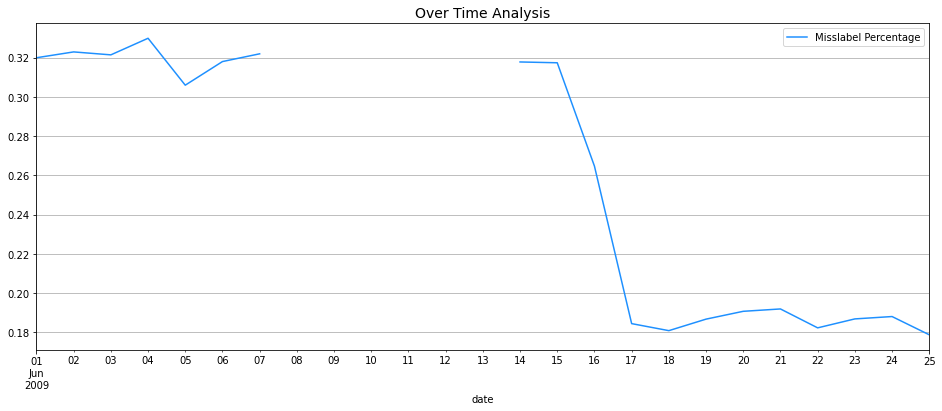

In [ ]:
error_quantity.plot(color="dodgerblue", grid=True, figsize=(16, 6))
plt.title("Over Time Analysis", fontsize=14)
plt.legend(["Misslabel Percentage"])
plt.show()